# Detecting an on AC from collected data
This notebook uses two python scripts that collect temperature and audio data, and afterwards graphs that data and cross-references that data with a trained AI model to check at which moments the AC was on

### Data Collection

In [2]:
import subprocess

The python scripts that are used to collect data are found in the current `AC_Detector` directory:
1. `collectData.py` - collects temperature readings, along with other things, using the environmental sensor and stores them in a .csv file in `collected_data/`
2. `logVolume.py` - records audio, stores the files in `collected_data/audio_samples/`, and saves volume data in a .csv file in `collected_data/`

These scripts are command-line executable

In [10]:
# arguments for collectData.py:
burn_interval = 0 # time between each burn in run (seconds); keep at 0
burn_duration = 0 # burn in time (minutes); keep at 0
run_interval = 1 # time between each data collection (seconds)
run_duration = 1 # time for total data collection (minutes) **for some reason this runs for two minutes**
envi_file_name = 'tempLog_2min.csv'

## *****we need to fuind a way to align both data collections in the amount of time they take data

# arguments for logVolume.py:
interval = 5 # time between each sample (seconds)
duration = 5 # duration of each sample (seconds)
total_time = 2 # total run time (minutes) **this actually runs for three minutes
file_name = 'volumeLog_2min.csv'

The process below collects temperature and audio data simultaneously 

In [9]:
collect_data = f"python3 collectData.py {burn_interval} {burn_duration} {run_interval} {run_duration} {envi_file_name}"
logVolume = f"python3 logVolume.py {interval} {duration} {total_time} {file_name}"
subprocess.run(collect_data + "&" + logVolume, shell=True)

CompletedProcess(args='python3 collectData.py 0 0 1 1 tempLog_2min.csv&python3 logVolume.py 5 5 2 volumeLog_2min.csv', returncode=0)

### Data Analysis

In [11]:
import numpy as np
import datetime
from matplotlib import pyplot as plt

We will now graph the audio data

In [12]:
# loading the collected data into memory
temp = np.loadtxt("collected_data/" + envi_file_name, delimiter=",")
audio = np.loadtxt("collected_data/" + file_name, delimiter=",")

In [13]:
# helper function for transforming nanosecond format of the .csv to readable timestamps
def toDate(t):
    return datetime.datetime.fromtimestamp(t / 1e9)
vToDate = np.vectorize(toDate)

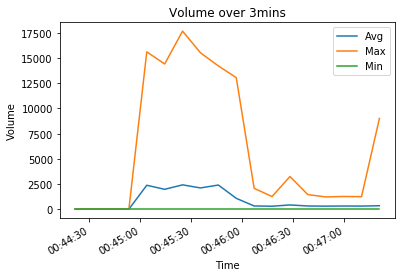

In [14]:
plt.plot(vToDate(audio[1:, 0]), audio[1:,1], label='Avg')
plt.plot(vToDate(audio[1:, 0]), audio[1:,2], label='Max')
plt.plot(vToDate(audio[1:, 0]), audio[1:,3], label='Min')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title("Volume over 3mins")
plt.gcf().autofmt_xdate()

We will graph the average volume with the temperature readings

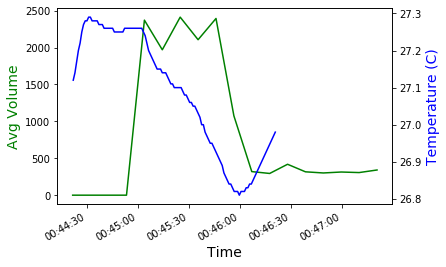

In [15]:
fig,ax = plt.subplots()
ax.plot(vToDate(audio[1:, 0]), audio[1:,1], color="green", label='Avg')
ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("Avg Volume",color="green",fontsize=14)

ax2=ax.twinx()
ax2.plot(vToDate(temp[1:, 0]), temp[1:,1], color="blue")
ax2.set_ylabel("Temperature (C)",color="blue",fontsize=14)
plt.gcf().autofmt_xdate()
plt.show()

Let's check which audio files and their timestamps have the AC on using the trained AI model  
Recall the `AC AI.ipynb` notebook trained an audio model to detect different urban noises. We will use that same model to examine the validity of when the AC was on by cross referencing the evaluation of each audio file with the graphs above

In [16]:
import os
import re
from pyAudioAnalysis import audioTrainTest as aT

In [17]:
# thr_prre, pre, rec, thr_roc, fpr, tpr = aT.evaluate_model_for_folders("collected_data/audio_samples/*", "urbanSounds", "svm", "urbanSounds")
# could not get this to work

In [19]:
directory = "collected_data/audio_samples/"
pattern = r'\d+'
timestamps_ac_on = []
timestamps_ac_off = []
for file in os.listdir(directory):
    class_id, probability, classes = aT.file_classification(directory + file, 
                                                           "urbanSounds", "svm")
    time = toDate(int(re.findall(pattern, file)[0]))
    if class_id == 0 and probability[0] > 0.8:
        timestamps_ac_on.append(time)
    else:
        timestamps_ac_off.append(time)
    
    os.unlink(directory + file) # optional to delete created audio files
print(timestamps_ac_on)
print(timestamps_ac_off)

[datetime.datetime(2021, 8, 28, 0, 46, 49, 3368), datetime.datetime(2021, 8, 28, 0, 46, 27, 988731), datetime.datetime(2021, 8, 28, 0, 46, 17, 482311), datetime.datetime(2021, 8, 28, 0, 47, 20, 524561), datetime.datetime(2021, 8, 28, 0, 45, 14, 427372), datetime.datetime(2021, 8, 28, 0, 45, 35, 443461), datetime.datetime(2021, 8, 28, 0, 46, 38, 495682), datetime.datetime(2021, 8, 28, 0, 46, 59, 507416), datetime.datetime(2021, 8, 28, 0, 45, 56, 471406), datetime.datetime(2021, 8, 28, 0, 46, 6, 975593), datetime.datetime(2021, 8, 28, 0, 45, 3, 921130), datetime.datetime(2021, 8, 28, 0, 45, 45, 963327), datetime.datetime(2021, 8, 28, 0, 45, 24, 936291)]
[datetime.datetime(2021, 8, 28, 0, 44, 21, 797992), datetime.datetime(2021, 8, 28, 0, 44, 53, 411903), datetime.datetime(2021, 8, 28, 0, 44, 32, 395917), datetime.datetime(2021, 8, 28, 0, 44, 42, 903612), datetime.datetime(2021, 8, 28, 0, 47, 10, 15252)]
